In [1]:
import sys
sys.executable

'c:\\Users\\carlo\\miniforge3\\envs\\dtu02452\\python.exe'

In [27]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyedflib
from mne.time_frequency import psd_array_welch
from IPython.display import display
from scipy.signal import welch
from scipy.signal import coherence
from functions import preprocess_eeg, preprocess_ecg, extract_ecg_per_epoch, extract_resp_from_ecg, hrv_per_epoch, hep_metric, hpc_metric, classify_sleep_stable_unstable


In [3]:
data = Path(r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\n3.edf")
raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
raw.load_data()
raw.info["sfreq"], len(raw.ch_names), raw.ch_names[:10]

Reading 0 ... 16927231  =      0.000 ... 33060.998 secs...


C:\Users\carlo\AppData\Local\Temp\ipykernel_10876\716928837.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_10876\716928837.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)


(512.0,
 23,
 ['Fp2-F4',
  'F4-C4',
  'C4-P4',
  'P4-O2',
  'F8-T4',
  'T4-T6',
  'FP1-F3',
  'F3-C3',
  'C3-P3',
  'P3-O1'])

In [4]:
print("Sampling frequency:", raw.info["sfreq"])
print("Duration (s):", raw.n_times / raw.info["sfreq"])

Sampling frequency: 512.0
Duration (s): 33061.0


In [5]:
txt_path = r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.txt"
df = pd.read_csv(txt_path, sep='\t', header=None, names=["Sleep Stage", "Position", "Time [hh:mm:ss]", "Event", "Duration[s]", "Location"], skiprows=22)
df.head()

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC
4,W,Unknown Position,23:09:19,SLEEP-S0,30,ROC-LOC


In [6]:
import importlib
import functions
importlib.reload(functions)

from functions import compute_stage_epochs, add_epoch_onsets

df = add_epoch_onsets(df, 30.0)

stages = ["W", "R", "S1", "S2", "S3", "S4"]

stage_dfs = {}

for stage in stages:
    stage_dfs[stage] = compute_stage_epochs(df, stage)

stage_dfs["R"][:5]


[(13620.0, 13650.0),
 (13650.0, 13680.0),
 (13680.0, 13710.0),
 (13710.0, 13740.0),
 (13740.0, 13770.0)]

In [7]:
wake_epochs = compute_stage_epochs(df, "W")
rem_epochs  = compute_stage_epochs(df, "R")
S1_epochs   = compute_stage_epochs(df, "S1")
S2_epochs   = compute_stage_epochs(df, "S2")
S3_epochs   = compute_stage_epochs(df, "S3")
S4_epochs   = compute_stage_epochs(df, "S4")

In [13]:
sf = raw.info["sfreq"]
eeg_filtered = preprocess_eeg(raw)
ecg_clean = preprocess_ecg(raw)

In [14]:
ecg_R  = extract_ecg_per_epoch(ecg_clean, ecg_clean, rem_epochs, sf)
ecg_S1 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S1_epochs, sf)
ecg_S2 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S2_epochs, sf)
ecg_S3 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S3_epochs, sf)
ecg_S4 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S4_epochs, sf)
ecg_W  = extract_ecg_per_epoch(ecg_clean, ecg_clean, wake_epochs, sf)

In [16]:
hrv_rem = hrv_per_epoch(ecg_clean, rem_epochs, sf)
hrv_s1 = hrv_per_epoch(ecg_clean, S1_epochs, sf)
hrv_s2 = hrv_per_epoch(ecg_clean, S2_epochs, sf)
hrv_s3 = hrv_per_epoch(ecg_clean, S3_epochs, sf)
hrv_s4 = hrv_per_epoch(ecg_clean, S4_epochs, sf)
hrv_wake = hrv_per_epoch(ecg_clean, wake_epochs, sf)

print("\nREM Table:")
print(hrv_rem.head())

c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packag


REM Table:
   epoch  start_s  hr_mean_bpm   rmssd_ms    sdnn_ms  pnn50_pct  n_beats    ok
0      0  13620.0    59.890484  41.632744  43.154069  28.571429       29  True
1      1  13650.0    61.239660  25.053023  21.103138   3.448276       30  True
2      2  13680.0    61.287312  28.901254  29.765690   6.896552       30  True
3      3  13710.0    61.807727  25.142590  21.025971   3.448276       30  True
4      4  13740.0    62.145602  26.876387  19.169261   0.000000       30  True


In [22]:
resp = extract_resp_from_ecg(ecg_clean, sf)

hpc_s1 = hpc_metric(ecg_clean, resp, S1_epochs, sf, window_epochs=3)
hpc_s2 = hpc_metric(ecg_clean, resp, S2_epochs, sf, window_epochs=3)
hpc_s3 = hpc_metric(ecg_clean, resp, S3_epochs, sf, window_epochs=3)
hpc_s4 = hpc_metric(ecg_clean, resp, S4_epochs, sf, window_epochs=3)
hpc_rem = hpc_metric(ecg_clean, resp, rem_epochs, sf, window_epochs=3)
hpc_wake = hpc_metric(ecg_clean, resp, wake_epochs, sf, window_epochs=3)

print("\nREM Table:")
print(hpc_rem.head())


REM Table:
   epoch           HFC           LFC   LFC/HFC    ok
0      0  2.092396e-11  5.808359e-14  0.002776  True
1      3  4.164816e-11  8.334595e-14  0.002001  True
2      6  3.475907e-11  9.778974e-13  0.028134  True
3      9  3.784282e-11  5.304500e-13  0.014017  True
4     12  4.341444e-11  6.650781e-13  0.015319  True


In [23]:
hpc_rem = classify_sleep_stable_unstable(hpc_rem)
hpc_s1 = classify_sleep_stable_unstable(hpc_s1)
hpc_s2 = classify_sleep_stable_unstable(hpc_s2)
hpc_s3 = classify_sleep_stable_unstable(hpc_s3)
hpc_s4 = classify_sleep_stable_unstable(hpc_s4)
hpc_wake = classify_sleep_stable_unstable(hpc_wake)

print("\nREM Table:")
print(hpc_rem.head())
print(hpc_rem["sleep_stability"].value_counts(normalize=True))


REM Table:
   epoch           HFC           LFC   LFC/HFC    ok sleep_stability
0      0  2.092396e-11  5.808359e-14  0.002776  True          stable
1      3  4.164816e-11  8.334595e-14  0.002001  True          stable
2      6  3.475907e-11  9.778974e-13  0.028134  True          stable
3      9  3.784282e-11  5.304500e-13  0.014017  True          stable
4     12  4.341444e-11  6.650781e-13  0.015319  True          stable
sleep_stability
stable      0.97619
unstable    0.02381
Name: proportion, dtype: float64


In [32]:
import importlib
import functions
importlib.reload(functions)
from functions import hep_metric

hep_rem = hep_metric(eeg_filtered, ecg_clean, rem_epochs, sf)
hep_s1 = hep_metric(eeg_filtered, ecg_clean, S1_epochs, sf)
hep_s2 = hep_metric(eeg_filtered, ecg_clean, S2_epochs, sf)
hep_s3 = hep_metric(eeg_filtered, ecg_clean, S3_epochs, sf)
hep_s4 = hep_metric(eeg_filtered, ecg_clean, S4_epochs, sf)
hep_wake = hep_metric(eeg_filtered, ecg_clean, wake_epochs, sf)

print("\nREM Table:")
print(hep_rem.head())



REM Table:
   epoch  hep_mean_amp  n_beats_used    ok
0      0     -0.000037            29  True
1      1     -0.000397            30  True
2      2     -0.000466            30  True
3      3     -0.000182            30  True
4      4     -0.000209            30  True


NameError: name 'stage_name' is not defined

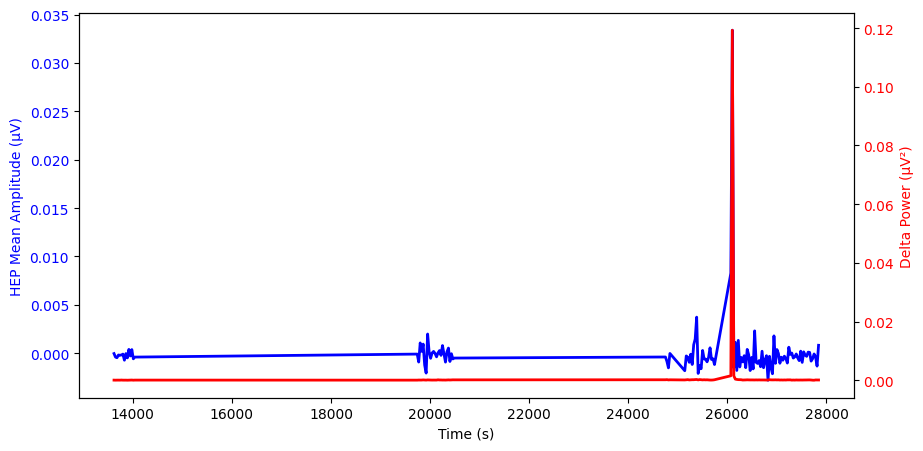

In [39]:
import importlib
import functions
importlib.reload(functions)

from functions import eeg_bandpower_per_epoch, HEP_Delta_plot

# Plot HEP amplitude distribution and delta oscillations amplitude 
power_rem = eeg_bandpower_per_epoch(eeg_filtered, rem_epochs, sf)


HEP_Delta_plot(hep_rem, power_rem)


In [38]:
merged = pd.merge(hep_rem, power_rem, on="epoch")
merged.head()

,epoch,hep_mean_amp,n_beats_used,ok,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,0,-0.000037,29,True,13620.0,0.000079,0.000009,1.958502e-07,2.308176e-07,4.305151e-08
1,1,-0.000397,30,True,13650.0,0.000063,0.000009,1.898473e-07,1.609951e-07,2.945648e-08
2,2,-0.000466,30,True,13680.0,0.000078,0.000007,2.109459e-07,2.746959e-07,5.154858e-08
3,3,-0.000182,30,True,13710.0,0.000080,0.000013,1.896343e-07,1.482361e-07,2.713642e-08
4,4,-0.000209,30,True,13740.0,0.000070,0.000013,1.732325e-07,1.067987e-07,1.905931e-08
